In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage
from skimage.transform import resize
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
#import tqdm.notebook as tqdm

%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


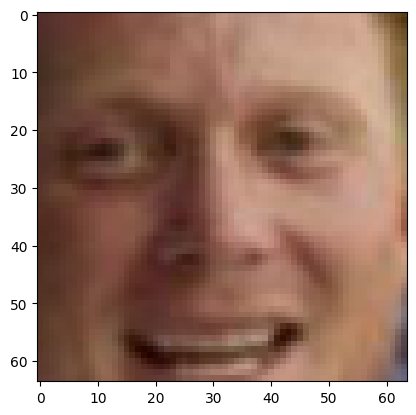

In [4]:
plt.imshow(data[1])

In [7]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split([i.astype(np.float32) for i in data], attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [8]:
dim_code = 32 
features = dim_code/2

In [32]:
class VanAE(torch.nn.Module):
  def __init__(self):
    super(VanAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = (self.decoder(latent))
    return reconstructed

In [10]:
def fit_epoch(model, train_loader, loss_fn):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    return(np.mean(train_losses_per_epoch))

In [11]:
def val_epoch(model, val_loader, loss_fn):
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in tqdm(val_loader):
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())
    return(np.mean(val_losses_per_epoch))

In [33]:
n_epochs = 30
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = VanAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
  
    train_losses.append(fit_epoch(model, train_loader, loss_fn))

    val_losses.append(val_epoch(model, val_loader, loss_fn))

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

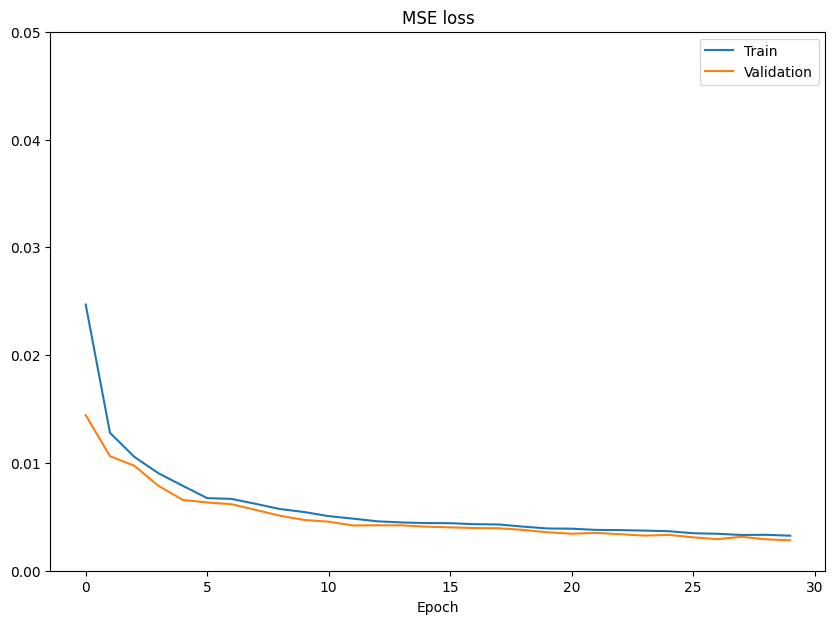

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [35]:
attrs_s=attrs[['Smiling']]

c_smil = 0
c_sad = 0
smiling = []
sad = []
c = 0
num = 30

for i in data:
  if (attrs.iloc[c]['Smiling'] > 0.5) and (c_smil < num ):
    c_smil += 1
    smiling.append((model.encoder(torch.FloatTensor(i).to(device))).cpu().detach().numpy())

  if (attrs.iloc[c]['Smiling'] < -0.5) and (c_sad < num ):
    c_sad += 1
    sad.append((model.encoder(torch.FloatTensor(i).to(device))).cpu().detach().numpy())

  if ((c_smil >= num ) and (c_sad >= num )): break
  c+=1

smile_vec = np.mean(smiling, axis=0)
sad_vec = np.mean(sad, axis=0)
res_vec = smile_vec - sad_vec

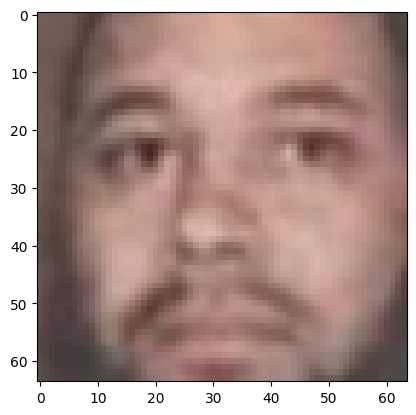

In [24]:

plt.imshow(data[2])

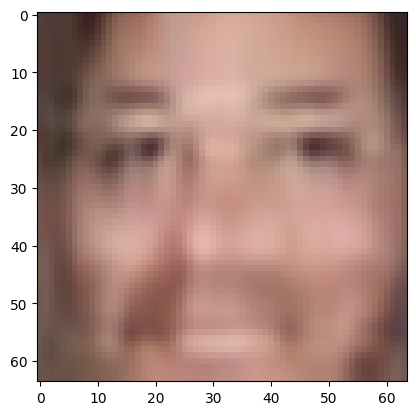

In [36]:
out = (model.encoder(torch.FloatTensor(data[2]).to(device))).cpu().detach().numpy() + res_vec
output = (model.decoder(torch.FloatTensor(out).to(device))).cpu().detach().numpy()

plt.imshow(output) # кек)))